# 简介

在前面的学习中，我们已经对强化学习有了不少了解。

无论是在线策略（on-policy）算法还是离线策略（off-policy）算法，**都有一个共同点**：
- 智能体在训练过程中可以不断和环境交互，得到新的反馈数据。

**二者的区别主要在于**：在线策略算法会直接使用这些反馈数据，而离线策略算法会先将数据存入经验回放池中，需要时再采样。

然而，在现实生活中的许多场景下，让尚未学习好的智能体和环境交互可能会导致危险发生，或是造成巨大损失。
- 例如，在训练自动驾驶的规控智能体时，如果让智能体从零开始和真实环境进行交互，那么在训练的最初阶段，它操控的汽车无疑会横冲直撞，造成各种事故。
- 再例如，在推荐系统中，用户的反馈往往比较滞后，统计智能体策略的回报需要很长时间。
- 而如果策略存在问题，早期的用户体验不佳，就会导致用户流失等后果。

因此，**离线强化学习（offline reinforcement learning）的目标是，在智能体不和环境交互的情况下，仅从已经收集好的确定的数据集中，通过强化学习算法得到比较好的策略**。

离线强化学习和在线策略算法、离线策略算法的区别如图 18-1 所示。

In [1]:
from IPython.display import Image

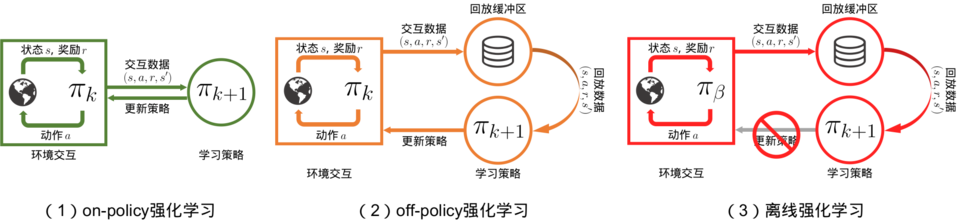

In [2]:
Image(filename='./image/on-off-policy.png',width=600)

# 批量限制 Q-learning 算法

图 18-1 中的**离线强化学习**和**离线策略强化学习**很像，**都要从经验回放池中采样进行训练**，并且离线策略算法的策略评估方式也多种多样。

因此，研究者们最开始尝试**将离线策略算法直接照搬到离线的环境下，仅仅是去掉算法中和环境交互的部分**。**然而，这种做法完全失败了**。

**研究者进行了 3 个简单的实验:**
- 第一个实验(**完全回放**)，使用 DDPG 算法训练了一个智能体，并将智能体与环境交互的所有数据都记录下来，再用这些数据训练离线 DDPG 智能体。
- 第二个实验(**同步训练**)，**在线 DDPG 算法**在训练时每次从经验回放池中采样，并用相同的数据同步训练离线 DDPG 智能体，这样两个智能体甚至连训练时用到的**数据顺序**都完全相同。
- 第三个实验(**模仿训练**)，在线 DDPG 算法在训练完毕后作为专家，在环境中采集大量数据，供离线 DDPG 智能体学习。

这 3 个实验，即完全回放、同步训练、模仿训练的结果依次如图 18-2 所示。

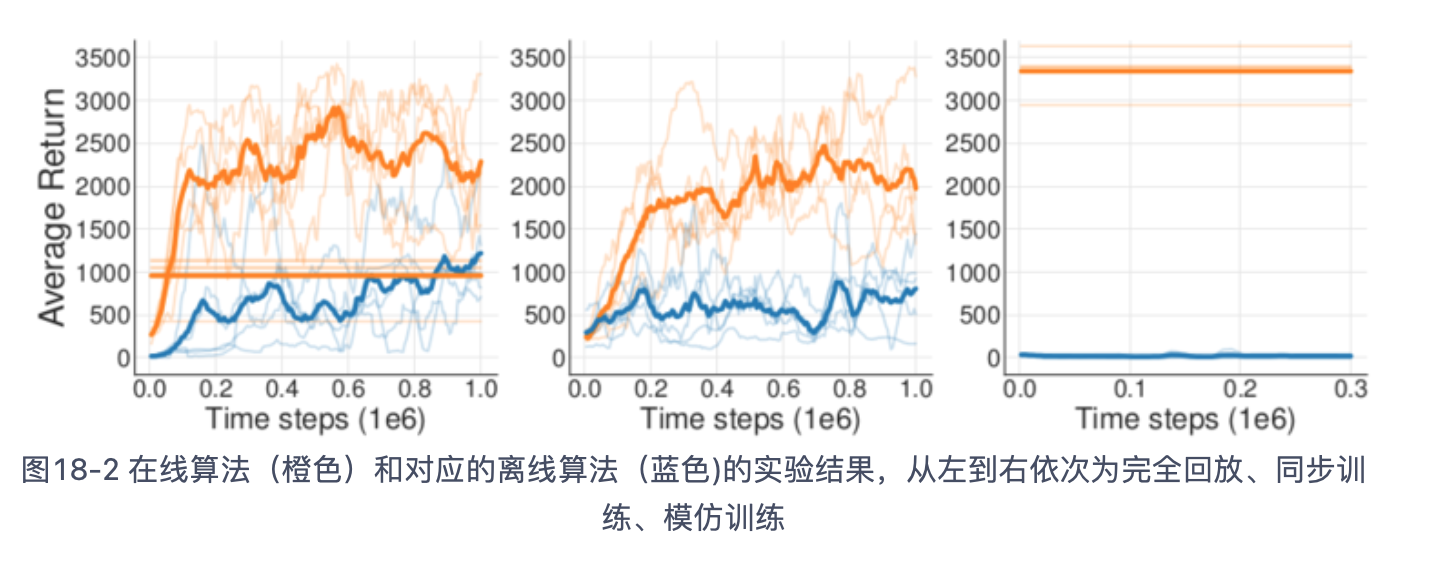

In [3]:
Image(filename='./image/compare3.png',width=600)

让人惊讶的是，**3 个实验中，离线 DDPG 智能体的表现都远远差于在线 DDPG 智能体**，

即便是第二个实验的同步训练都无法提高离线智能体的表现。

在第三个模仿训练实验中，离线智能体面对非常优秀的数据样本却什么都没学到！

针对这种情况，研究者指出，**外推误差（extrapolation error）是离线策略算法不能直接迁移到离线环境中的原因**。

### **外推误差**:
- 是指由于当前策略可能访问到的状态动作对(s,a)与从数据集中采样得到的状态动作对的**分布不匹配而产生的误差**。

**为什么在线强化学习算法没有受到外推误差的影响呢？** 
- 因为对于在线强化学习，**即使训练是离线策略的，智能体依然有机会通过与环境交互及时采样到新的数据，从而修正这些误差。**
- 但是在离线强化学习中，智能体无法和环境交互。

因此，一般来说，**离线强化学习算法要想办法尽可能地限制外推误差的大小，从而得到较好的策略。**

**为了减少外推误差，当前的策略需要做到只访问与数据集中相似的(s,a)数据。**

**满足这一要求的策略称为批量限制策略（batch-constrained policy）**。
- 具体来说，**这样的策略在选择动作时有 3 个目标：**
    - **最小化**选择的动作与数据集中数据的**距离**；
    - 采取动作后能到达与离线数据集中状态**相似的状态**；
    - 最大化函数Q。
    
#### 对于标准的表格（tabular）型环境，状态和动作空间都是离散且有限的。

**标准的 Q-learning 更新公式可以写为：**
$Q(s,a) ← (1-α)Q(s,a) + α(r + γQ(s`,argmax_{a`}Q(s`,a`))$

这时，**只需要把策略能选择的动作限制在数据集D内** ，就能满足上述 3 个目标的平衡，这样就得到了**表格设定下**的**批量限制 Q-learning（batch-constrained Q-learning，BCQ）算法**：

$Q(s,a) ← (1-α)Q(s,a) + α(r + γQ(s`,argmax_{a` s.t.(s`,a`)∈ D}Q(s`,a`))$


可以证明，如果数据中包含了所有可能的（s,a）对，按上式进行迭代可以**收敛到最优的价值函数** $Q^*$。

#### **连续**状态和动作的情况要复杂一些，因为批量限制策略的目标需要被更详细地定义。

- 例如，**该如何定义两个状态动作对的距离呢？**

BCQ 采用了一种巧妙的方法：
- **1、** 训练一个**生成模型** $G_w(s)$ 。
  - 对于数据集D 和其中的状态s，生成模型$G_w(s)$能给出与D中数据接近的一系列动作$a_1,...,a_n$用于Q网络的训练。
- **2、**更进一步，为了增加生成动作的**多样性** ，减少生成次数，BCQ 还引入了**扰动模型ξ_φ(s,a,ϕ)。**
  - 输入(s,a)时，模型给出一个绝对值最大为ϕ的微扰并附加在动作上。

**这两个模型综合起来相当于给出了一个批量限制策略π：**


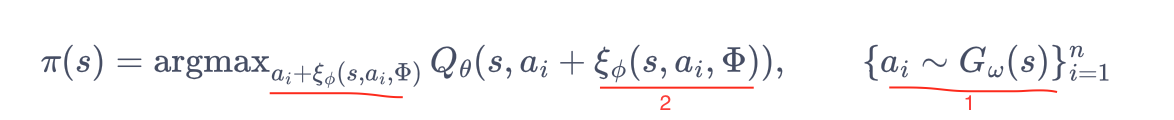

In [4]:
Image(filename='./image/batch_policy.png',width=600)

其中，
- **生成模型** $G_w(s)$用**变分自动编码器（variational auto-encoder, VAE）** 实现；
- **扰动模型** 直接通过确定性策略梯度算法训练，目标是使函数Q最大化：

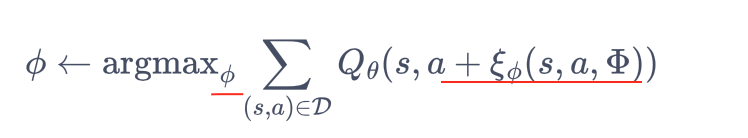

In [5]:
Image(filename='./image/maxQ.png',width=600)

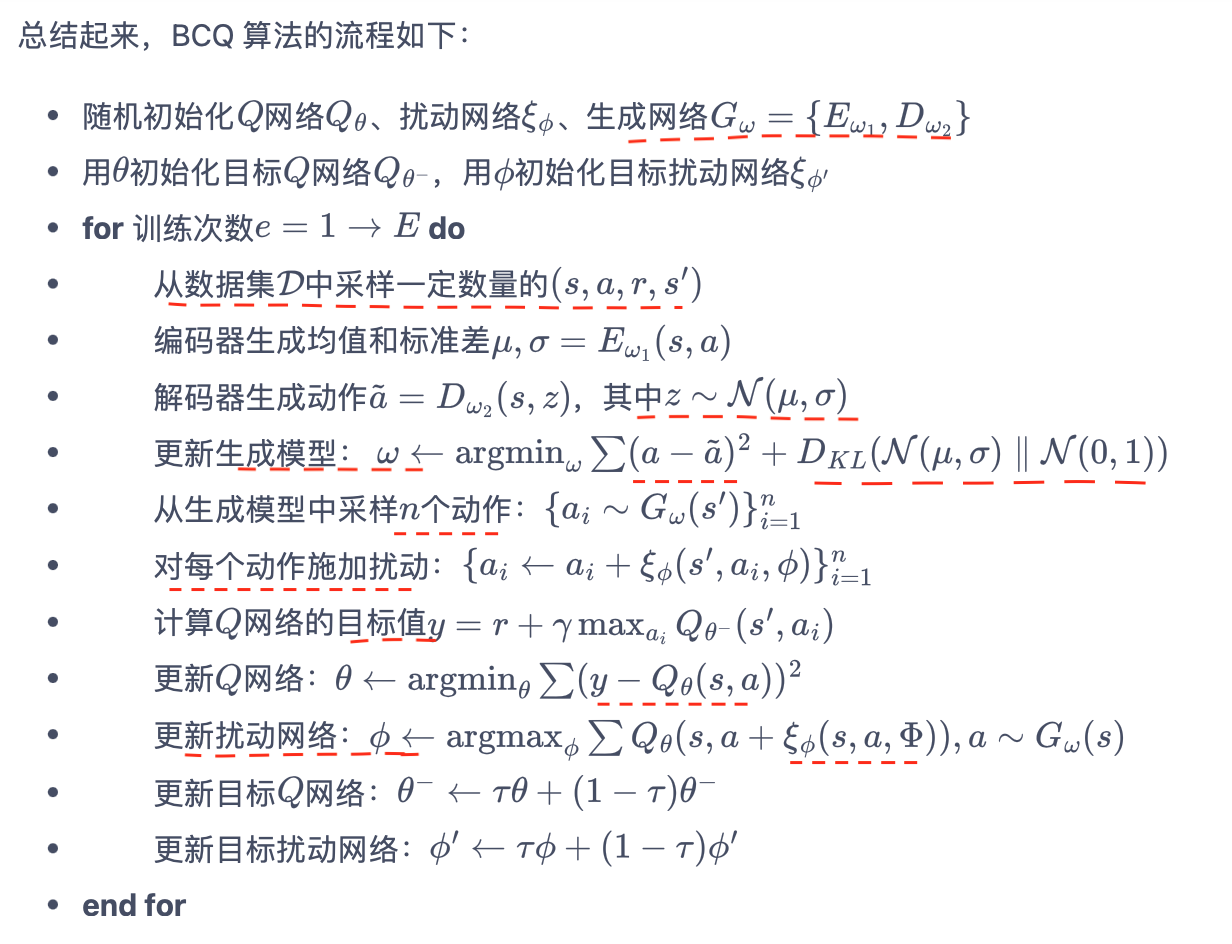

In [6]:
Image(filename='./image/bcq_step.png',width=600)

除此之外，BCQ 还使用了一些实现上的小技巧。

由于不是 BCQ 的重点，此处不再赘述。考虑到 VAE 不属于本书的讨论范围，并且 **BCQ 的代码中有较多技巧**，有兴趣的读者可以参阅 BCQ 原文，自行实现代码。

此处介绍 BCQ 算法:
- 一是因为**它对离线强化学习的误差分析和实验很有启发性**，
- 二是因为它是无模型离线强化学习中限制策略集合算法中的经典方法。

下面我们介绍另一类**直接限制Q函数的算法的代表：保守 Q-learning。**


## 保守 Q-learning 算法-- CQL

上一节已经讲到，**离线强化学习面对的巨大挑战是如何减少外推误差。**

**实验证明，外推误差主要会导致在远离数据集的点上函数Q的过高估计，甚至常常出现值向上发散的情况。**

因此，**如果能用某种方法将算法中偏离数据集的点上的函数Q保持在很低的值，或许能消除部分外推误差的影响，这就是保守 Q-learning（conservative Q-learning，CQL）算法的基本思想。**

CQL 在普通的贝尔曼方程上**引入一些额外的限制项，达到了这一目标**。

接下来一步步介绍 **CQL 算法的思路**。

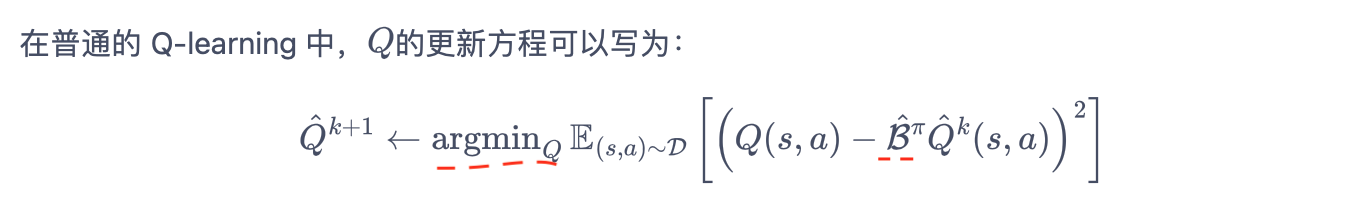

In [7]:
Image(filename='./image/cql_qlearning.png',width=600)

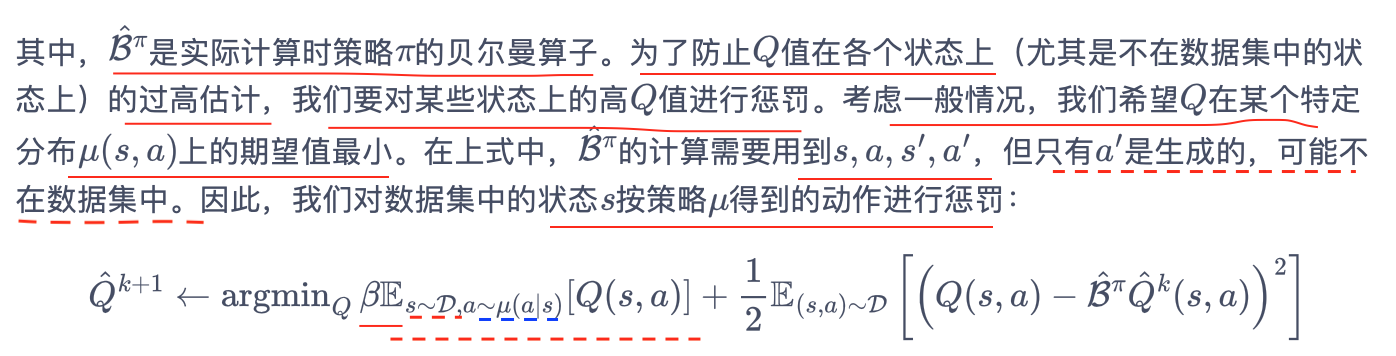

In [8]:
Image(filename='./image/cql_qlearing_01.png',width=600)

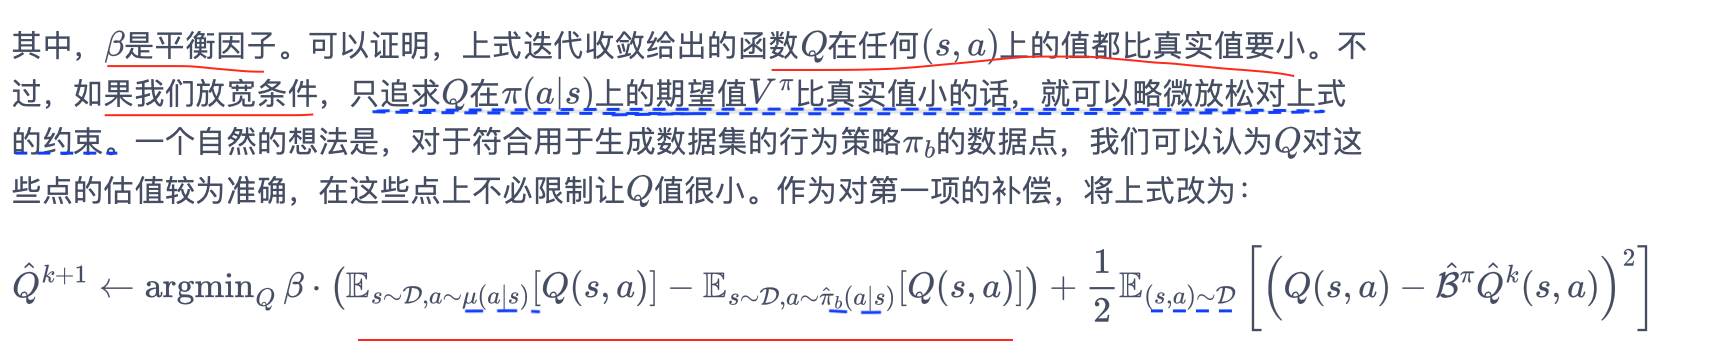

In [9]:
Image(filename='./image/cql_qlearing_02.png',width=600)

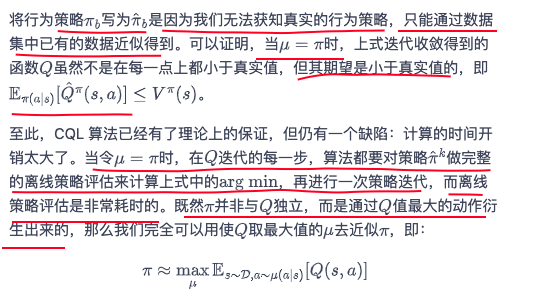

In [10]:
Image(filename='./image/cql_01.png',width=600)

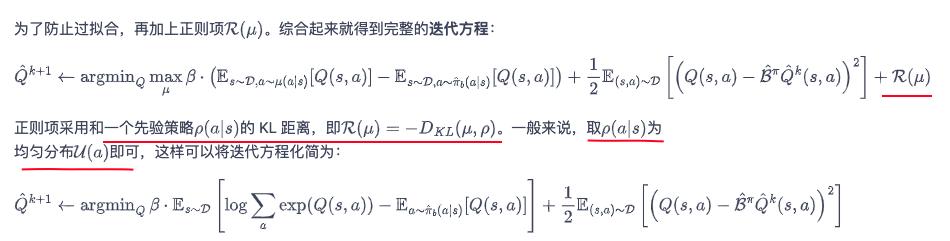

In [11]:
Image(filename='./image/cql_02.png',width=600)

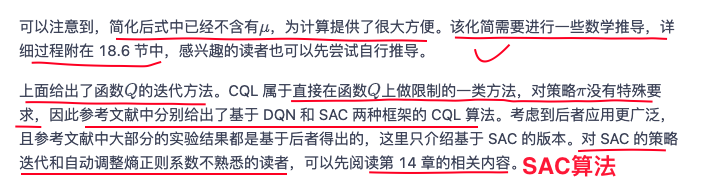

In [12]:
Image(filename='./image/cql_03.png',width=600)

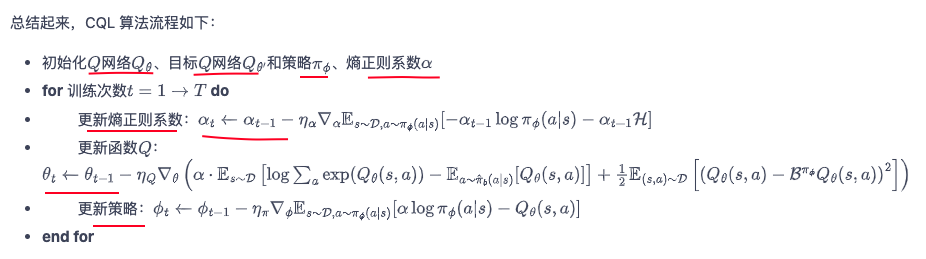

In [13]:
Image(filename='./image/cql_sac_step.png',width=600)

## CQL 代码实践

下面在倒立摆环境中实现基础的 CQL 算法。该环境在前面的章节中已出现了多次，这里不再重复介绍。

In [15]:
import numpy as np
import gym
from tqdm import tqdm
import random
import rl_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


为了生成数据集，在倒立摆环境中从零开始训练一个在线 SAC 智能体，直到算法达到收敛效果，把训练过程中智能体采集的所有轨迹保存下来作为数据集。

这样，**数据集中既包含训练初期较差策略的采样，又包含训练后期较好策略的采样，是一个混合数据集**。

下面给出生成数据集的代码，**SAC 部分直接使用 14.5 节中的代码**，因此不再详细解释。

In [17]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)


class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  #对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对倒立摆环境的奖励进行重塑

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)


env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

AttributeError: 'PendulumEnv' object has no attribute 'seed'

## 下面实现本章重点讨论的 CQL 算法，它在 SAC 的代码基础上做了修改

In [ ]:
class CQL:
    ''' CQL算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device, beta, num_random):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)
        
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)
        
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                                   action_dim).to(device)
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                                   action_dim).to(device)
        
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  #对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau

        self.beta = beta  # CQL损失函数中的系数
        self.num_random = num_random  # CQL中的动作采样数

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        action = self.actor(state)[0]
        return [action.item()]

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(device)
        
        rewards = (rewards + 8.0) / 8.0  # 对倒立摆环境的奖励进行重塑

        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        
        next_value = torch.min(q1_value,q2_value) + self.log_alpha.exp() * entropy
        
        td_target = rewards + self.gamma * next_value * (1 - dones)
        
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))

        # 以上与SAC相同,以下Q网络更新是CQL的额外部分
        batch_size = states.shape[0]
        random_unif_actions = torch.rand([batch_size * self.num_random, actions.shape[-1]],
            dtype=torch.float).uniform_(-1, 1).to(device)
        
        random_unif_log_pi = np.log(0.5**next_actions.shape[-1])
        
        tmp_states = states.unsqueeze(1).repeat(1, self.num_random,1).view(-1, states.shape[-1])
        
        tmp_next_states = next_states.unsqueeze(1).repeat(1, self.num_random, 1).view(-1, next_states.shape[-1])
        
        random_curr_actions, random_curr_log_pi = self.actor(tmp_states)
        random_next_actions, random_next_log_pi = self.actor(tmp_next_states)
        
        q1_unif = self.critic_1(tmp_states, random_unif_actions).view(
            -1, self.num_random, 1)
        q2_unif = self.critic_2(tmp_states, random_unif_actions).view(
            -1, self.num_random, 1)
        
        q1_curr = self.critic_1(tmp_states, random_curr_actions).view(
            -1, self.num_random, 1)
        q2_curr = self.critic_2(tmp_states, random_curr_actions).view(
            -1, self.num_random, 1)
        
        q1_next = self.critic_1(tmp_states, random_next_actions).view(
            -1, self.num_random, 1)
        q2_next = self.critic_2(tmp_states, random_next_actions).view(
            -1, self.num_random, 1)
        
        q1_cat = torch.cat([
            q1_unif - random_unif_log_pi,
            q1_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q1_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ],
                           dim=1)
        q2_cat = torch.cat([
            q2_unif - random_unif_log_pi,
            q2_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q2_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ],
                           dim=1)

        qf1_loss_1 = torch.logsumexp(q1_cat, dim=1).mean()
        qf2_loss_1 = torch.logsumexp(q2_cat, dim=1).mean()
        
        qf1_loss_2 = self.critic_1(states, actions).mean()
        qf2_loss_2 = self.critic_2(states, actions).mean()
        
        qf1_loss = critic_1_loss + self.beta * (qf1_loss_1 - qf1_loss_2)
        qf2_loss = critic_2_loss + self.beta * (qf2_loss_1 - qf2_loss_2)

        self.critic_1_optimizer.zero_grad()
        qf1_loss.backward(retain_graph=True)
        self.critic_1_optimizer.step()
        
        self.critic_2_optimizer.zero_grad()
        qf2_loss.backward(retain_graph=True)
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -torch.min(q1_value, q2_value))
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

**因为不能通过与环境交互来获得新的数据，离线算法最终的效果和数据集有很大关系，并且波动会比较大。**

通常来说，调参后数据集中的样本质量越高，算法的表现就越好。

感兴趣的读者可以使用其他方式生成数据集，并观察算法效果的变化。

In [ ]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

beta = 5.0
num_random = 5
num_epochs = 100
num_trains_per_epoch = 500

agent = CQL(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
            critic_lr, alpha_lr, target_entropy, tau, gamma, device, beta,
            num_random)

return_list = []
for i in range(10):
    with tqdm(total=int(num_epochs / 10), desc='Iteration %d' % i) as pbar:
        for i_epoch in range(int(num_epochs / 10)):
            # 此处与环境交互只是为了评估策略,最后作图用,不会用于训练
            epoch_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                state = next_state
                epoch_return += reward
            return_list.append(epoch_return)

            for _ in range(num_trains_per_epoch):
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                
                transition_dict = {
                    'states': b_s,
                    'actions': b_a,
                    'next_states': b_ns,
                    'rewards': b_r,
                    'dones': b_d
                }
                agent.update(transition_dict)

            if (i_epoch + 1) % 10 == 0:
                pbar.set_postfix({
                    'epoch':
                    '%d' % (num_epochs / 10 * i + i_epoch + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

In [ ]:
epochs_list = list(range(len(return_list)))
plt.plot(epochs_list, return_list)
plt.xlabel('Epochs')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

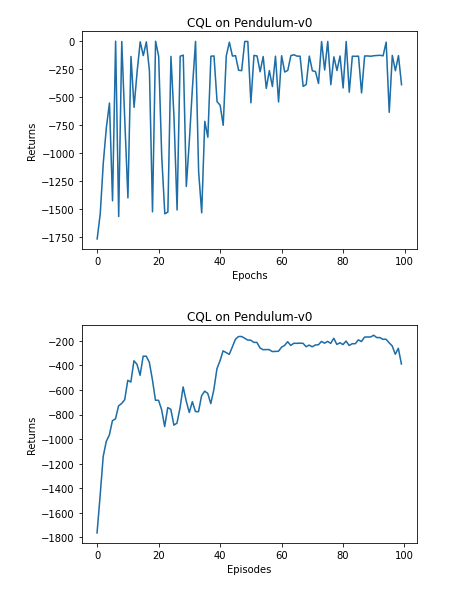

In [14]:
Image(filename='./image/cql_chart.png',width=600)

# 总结
本章介绍了离线强化学习的基本概念和两个与模型无关的离线强化学习算法——BCQ 和 CQL，并讲解了 CQL 的代码。

事实上，离线强化学习还有一类基于模型的方法，如 model-based offline reinforcement learning （MOReL）和 model-based offline policy optimization（MOPO），

本章由于篇幅原因不再介绍。**这一类算法的思路基本是通过模型生成更多数据，同时通过衡量模型预测的不确定性来对生成的偏离数据集的数据进行惩罚**，感兴趣的读者可以自行查阅相关资料。

## 离线强化学习的另一大难点是算法通常对超参数极为敏感，非常难调参。

并且在实际复杂场景中通常不能像在模拟器中那样，每训练几轮就在环境中评估策略好坏，如何确定何时停止算法也是离线强化学习在实际应用中面临的一大挑战。

此外，离线强化学习在现实场景中的落地还需要关注离散策略评估和选择、数据收集策略的保守性和数据缺失性等现实问题。

**不过无论如何，离线强化学习和模仿学习都是为了解决在现实中训练智能体的困难而提出的，也都是强化学习真正落地的重要途径。**

## 证明


# 18.7 参考文献

[1] LEVINE S, KUMAR A, TUCKER. G, et al. Offline reinforcement learning: tutorial, review, and perspectives on open problems [J]. 2020.

[2] FUJIMOTO S, MEGER D, PRECUP D. Off-policy deep reinforcement learning without exploration [C] // International conference on machine learning, PMLR, 2019.

[3] KINGMA D P, WELLING M. Auto-encoding variational bayes [C] // International conference on learning representations, ICLR, 2014.

[4] KUMAR A, ZHOU A, TUCKER G, et al. Conservative q-learning for offline reinforcement learning [J]. NeurIPS, 2020.

[5] KIDAMBL R, RAJESWARAN A, NETRAPALLI P, et al. MOReL: Model-based offline reinforcement learning [J]. Advances in neural information processing systems, 2020: 33.

[6] YU T, THOMAS G, YU L, et al. MOPO: Model-based offline policy optimization [J]. Advances in neural information processing systems, 2020: 33.